In [64]:
%matplotlib inline
import json
import os
import math
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from data import CodesInDbs, Mappings, Databases
from IPython.display import Latex

pd.set_option('display.max_colwidth', 100)

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2)
#plt.rcParams['figure.figsize'] = (4, 3)
#plt.rc("savefig", dpi=150)

measures_palette = sns.color_palette('Set1', n_colors=2, desat=.5)
measures_palette.reverse()

def graded_recall_palette(n_colors, rev=True):
    palette = sns.color_palette("Blues", n_colors=n_colors, desat=.6)
    if rev:
        palette.reverse()
    return palette

def graded_precision_palette(n_colors, rev=True):
    palette = sns.color_palette("Reds", n_colors=n_colors, desat=.6)
    if rev:
        palette.reverse()
    return palette

def mystyle(palette=None, xrot=0, ha='center', ylim=(0,1), ylabel=None, savefig=None):
    class C:
        def __enter__(self):
            if palette is not None:
                palette.__enter__()
        def __exit__(self, exc_type, value, traceback):
            if palette is not None:
                palette.__exit__(exc_type, value, traceback)
            if exc_type is None:
                ax = plt.gca()
                sns.despine(left=True, ax=ax)
                ax.grid(False, axis='x')
                if ax.legend_: 
                    lgd = ax.legend(loc=2, bbox_to_anchor=(1, 1))
                else:
                    lgd = None
                if ax.get_lines():
                    ax.get_lines()[0].set_visible(False)
                ax.set_ylim(*ylim)
                plt.xticks(rotation=xrot, ha=ha)
                if ylabel is not None:
                    ax.yaxis.label(ylabel)
                if savefig:
                    filename = '{}-{}'.format(PROJECT, savefig)
                    plt.savefig(filename, bbox_extra_artists=[lgd] if lgd else [], bbox_inches='tight')
    return C()

def draw_lines(ys, palette=None):
    if palette is None:
        palette = sns.color_palette()
    ax = plt.gca()
    ax.axhline(0, 0, 0) # First axhline is not visible??
    for y, color in zip(ys, palette):
        ax.axhline(y, color=color, zorder=-100)
    return ax

"""
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    #return r"\begin{center}%s\end{center}" % 
    return self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame
"""

PROJECT = 'safeguard' # os.getenv('COMAP_PROJECT')
print("PROJECT:", PROJECT)

PROJECT: safeguard


In [65]:
with open('../projects/{}/config.yaml'.format(PROJECT)) as f:
    config = yaml.load(f)
    databases = Databases.of_config(config)
    coding_systems = config['coding-systems']
    events = config["events"]
    variations = config['variations']
    event_names = {}
    for event in events:
        casedef = yaml.load(open('../projects/{}/case-definitions/{}.yaml'.format(PROJECT, event)))
        event_names[event] = casedef['name']

with open('../{}.mappings.json'.format(PROJECT)) as f:
    mappings = Mappings.of_data(json.load(f))

with open('../codes-in-dbs.json') as f:
    codes_in_dbs = CodesInDbs.of_data(json.load(f))

coding_systems = ["ICD-9", "ICD-10", "ICPC-2", "READ-2"]
    
def database_label(database):
    #return database
    #return "{} ({})".format(database, databases.coding_system(database))
    return {
        "ICD10CM": "ICD-10",
        "ICD10/CM": "ICD-10",
        "RCD2": "READ-2",
        "ICPC2EENG": "ICPC-2",
        "ICD9CM": "ICD-9",
    }[databases.coding_system(database)]

def measure_label(measure):
    return {
        "recall": "Sensitivity",
        "precision": "PPV", # "Positive predictive value",
    }[measure]

def event_label(event):
    return event_names[event]

def len_if_notnull(x):
    if x != x:
        return 0
    else:
        return len(x)

## Load evaluations `ev`

In [66]:
ev = pd.read_csv('../{}.evaluations.csv'.format(PROJECT))
for key in ['generated', 'reference', 'tp', 'fp', 'fn']:
    ev[key] = ev[key].map(lambda x: x if x != x else json.loads(x))
ev['variation event database recall precision'.split()].head()

,variation,event,database,recall,precision
0,baseline0,va,IPCI,0.000000,0.000000
1,baseline0,va,CPRD,0.185185,0.416667
2,baseline0,va,GePaRD,0.400000,0.285714
3,baseline0,va,Medicare,0.600000,0.600000
4,baseline0,hs,IPCI,0.000000,NaN


## Mappings

In [67]:
df_m = mappings.describe()
df_m.index = df_m.index.map(database_label)
df_m.columns = df_m.columns.map(event_label)
df_m.index.name = 'Inclusion codes'
df_m['Sum'] = df_m.iloc[:4,:7].sum(axis=1)
df_m['Average'] = df_m.iloc[:4,:7].mean(axis=1).round(2)
#df.ix['Sum'] = df.iloc[:4, :7].sum()
#df.ix['Average'] = df.iloc[:4, :7].mean().round(2)
#df.ix['Sum']['Sum'] = df['Sum'].sum()
#df.ix['Average']['Average'] = df['Average'].mean()
df_m.fillna('-').T[['ICD-9', 'ICD-10', 'ICPC-2', 'READ-2']]

df_e = mappings.describe(exclusions=True)

df_e.index = df_e.index.map(database_label)
df_e.columns = df_e.columns.map(event_label)
df_e.index.name = 'Exclusion codes'

df_e['Sum'] = df_e.iloc[:4,:7].sum(axis=1)
df_e['Average'] = df_e.iloc[:4,:7].mean(axis=1).round(2)
df_e.fillna('-').T[['ICD-9', 'ICD-10', 'ICPC-2', 'READ-2']]

def combine_pair(t):
    return '{} ({})'.format(t.inc, t.exc)
                                  
def combine_row(inc, exc):
    return (pd.DataFrame({'inc': inc.fillna('-'), 'exc': exc.fillna('-')})
              .apply(combine_pair, axis=1))

df = (df_m.combine(df_e, combine_row)
      .T[['ICD-9', 'ICD-10', 'ICPC-2', 'READ-2']])
df.index.nam = 'Events'
df

Inclusion codes,ICD-9,ICD-10,ICPC-2,READ-2
Acute Pancreatitis,1.0 (-),6.0 (-),1.0 (-),7.0 (-)
Bladder cancer,12.0 (-),12.0 (-),1.0 (3.0),91.0 (-)
Hemorrhagic stroke,3.0 (2.0),22.0 (2.0),1.0 (2.0),36.0 (-)
Ischemic stroke,10.0 (-),11.0 (-),2.0 (1.0),20.0 (-)
Myocardial Infarction,11.0 (10.0),7.0 (-),1.0 (6.0),- (-)
Pancreatic Cancer,8.0 (-),9.0 (-),1.0 (1.0),109.0 (-)
Ventricular Arrhythmia,5.0 (-),5.0 (-),1.0 (1.0),27.0 (-)
Sum,50.0 (12.0),72.0 (2.0),8.0 (14.0),290.0 (-)
Average,7.14 (6.0),10.29 (2.0),1.14 (2.33),48.33 (-)


# Notes

#### Should exclusion codes from the reference be generated?

No. Exclusion codes are often added database specifically, where the codes are *not* represented in the case definition.

# Coding systems

In [68]:
pd.DataFrame([
    (database, databases.coding_system(database), database_label(database))
    for database in databases.databases()
], columns=("Database", "Coding system", "Label")).set_index("Database")

,Coding system,Label
Database,,
Medicare,ICD9CM,ICD-9
IPCI,ICPC2EENG,ICPC-2
CPRD,RCD2,READ-2
GePaRD,ICD10/CM,ICD-10


## Baseline-0

### DISO filtering for concepts
Number / Percentage of concepts with true positive codes overall (`All`) and in semantic group *disorders* (`DISO`).

In [69]:
types_distr = pd.DataFrame(json.load(open('../{}.types-distrs.json'.format(PROJECT)))).T

df = pd.DataFrame()
df['All'] = types_distr.groupby('group')[['pos', 'neg']].sum().sum()
df['All %'] =  df['All'] / df['All'].sum()
df['DISO'] = types_distr.groupby('group')[['pos', 'neg']].sum().ix['DISO']
df['DISO %'] = df['DISO'] / df['DISO'].sum()
df

,All,All %,DISO,DISO %
pos,14,0.177215,14,0.304348
neg,65,0.822785,32,0.695652


Number of concepts in each mapping

In [70]:
df = (ev[ev.variation == 'baseline0'].
      groupby('event').
      first().
      cuis.
      map(json.loads).
      map(len).
      to_frame('#CUIs'))
df.index = df.index.map(event_label)
df.ix['SUM'] = df['#CUIs'].sum()
df.T

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,SUM
#CUIs,8,15,7,7,9,8,23,77


Number of generated, reference codes and confusion by coding system.

In [71]:
df = ev[ev.variation == 'baseline0'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in ['generated', 'reference', 'tp', 'fp', 'fn']:
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df.groupby('database').sum()

,generated,reference,tp,fp,fn
database,,,,,
ICD-10,32,72,11,21,61
ICD-9,22,50,9,13,41
ICPC-2,7,8,3,4,5
READ-2,49,290,25,24,265


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,0.300,0.195,0.357,0.131,0.246
PPV,0.322,0.380,0.500,0.373,0.394


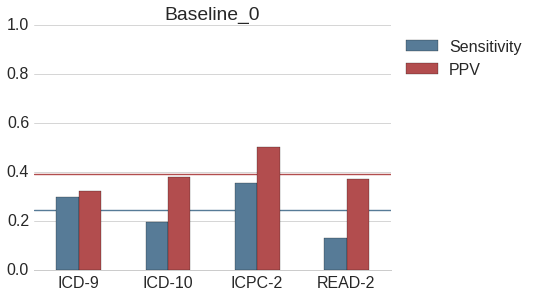

In [72]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline0'].groupby('database').recall.mean(),
    ev[ev.variation == 'baseline0'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, savefig='baseline-performance-by-db.pdf'):
    with sns.plotting_context(font_scale=1):
        ax = draw_lines(df['Average'])
        df.iloc[:,:-1].T.plot(kind='bar', title='Baseline_0', ax=ax)

baseline0_performance = df

df.round(3)

# Baseline

In [73]:
df = ev[ev.variation == 'baseline'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in 'generated reference tp fp fn'.split():
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df.groupby('database').sum()

,generated,reference,tp,fp,fn
database,,,,,
ICD-10,32,72,11,21,61
ICD-9,21,50,9,12,41
ICPC-2,6,8,3,3,5
READ-2,44,290,25,19,265


Number of concepts in the mapping

In [74]:
df = (ev[ev.variation == 'baseline'].
      groupby('event').
      first().
      cuis.
      map(json.loads).
      map(len).
      to_frame('#CUIs'))
df.index = df.index.map(event_label)
df.ix['SUM'] = df['#CUIs'].sum()
df.T

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,SUM
#CUIs,5,9,4,4,3,5,16,46


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,0.300,0.195,0.357,0.131,0.246
PPV,0.387,0.380,0.500,0.411,0.420


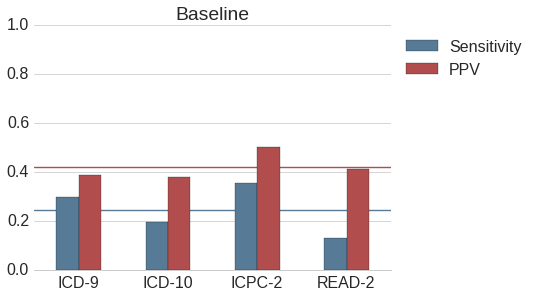

In [75]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('database').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, savefig='baseline-performance-by-db.pdf'):
    with sns.plotting_context(font_scale=1):
        ax = draw_lines(df['Average'])
        df.iloc[:,:-1].T.plot(kind='bar', title='Baseline', ax=ax)

baseline_performance = df

df.round(3)

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,Average
Sensitivity,0.399,0.402,0,0.170,0.048,0.384,0.296,0.243
PPV,0.211,0.522,0,0.667,0.500,0.625,0.335,0.409


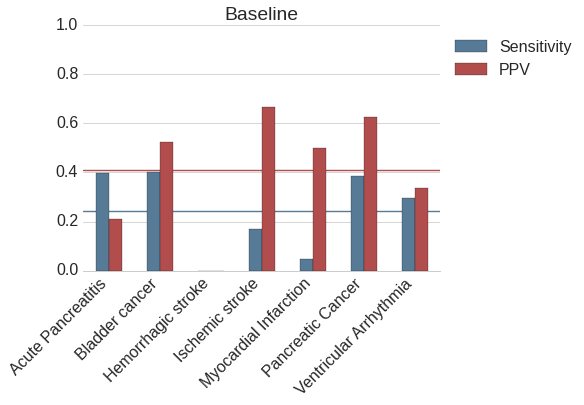

In [76]:
df = pd.DataFrame([
    ev[ev.variation == 'baseline'].groupby('event').recall.mean(),
    ev[ev.variation == 'baseline'].groupby('event').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(event_label)
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, xrot=45, ha='right', savefig='baseline-performance-by-event.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', title='Baseline', ax=ax)
    
df.round(3)

# Max-recall

In [77]:
df = ev[ev.variation == 'max-recall'][['event', 'database', 'generated', 'reference', 'tp', 'fp', 'fn']]
for key in ['generated', 'reference', 'tp', 'fp', 'fn']:
    df[key] = df[key].map(len_if_notnull)
df['database'] = df['database'].map(database_label)
df = df.groupby('database').sum()
df.ix['Overall'] = df.sum()
df['fn/reference'] = df['fn'] / df['reference']
#df['tp/generated'] = 1 - (df.tp / df.generated).round(3)
df.round(3)

,generated,reference,tp,fp,fn,fn/reference
database,,,,,,
ICD-10,148,72,72,76,0,0.000
ICD-9,107,50,50,57,0,0.000
ICPC-2,10,8,8,2,0,0.000
READ-2,310,290,279,31,11,0.038
Overall,575,420,409,166,11,0.026


,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,1.000,1.000,1.000,0.966,0.991
PPV,0.612,0.608,0.857,0.855,0.733


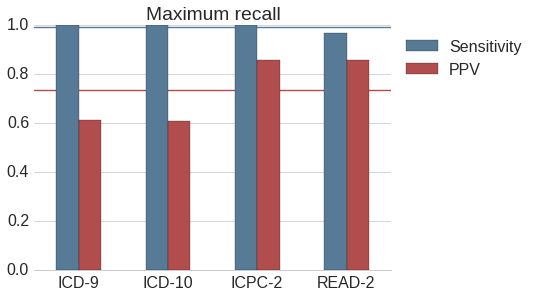

In [78]:
df = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
    ev[ev.variation == 'max-recall'].groupby('database').precision.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, ylim=(0,1), savefig='max-recall-performance-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', title='Maximum recall', ax=ax)
    
maxrecall_performance = df
    
df.round(3)

,ICD-9,ICD-10,ICPC-2,READ-2,Average
Sensitivity,1,1,1,0.966,0.991


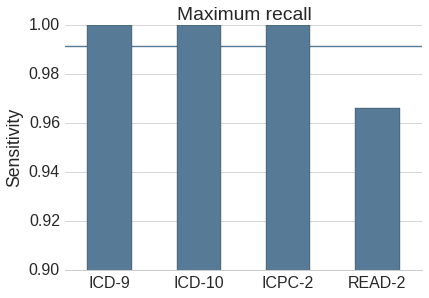

In [79]:
df = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('database').recall.mean(),
])
df.index = df.index.map(measure_label)
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(measures_palette, ylim=(.9, 1), savefig='max-recall-recall-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:,:-1].T.plot(kind='bar', legend=False, title='Maximum recall', ax=ax)
    plt.ylabel(measure_label('recall'))
    
df.round(3)

## Reasons for imperfect sensitivity

In [80]:
with open('../{}.code-stats.csv'.format(PROJECT)) as f:
    code_stats = pd.read_csv(f)
    
stats = pd.DataFrame()
stats['Mapping'] = (code_stats[code_stats.InMapping]
                    .groupby('Database')
                    .Code.count())
stats['Not maximum-recall'] = (code_stats[code_stats.InMapping & ~code_stats.InDnf]
                               .groupby('Database')
                               .Code.count())
stats = stats.fillna(0)
stats['% of missing'] = (stats['Not maximum-recall'] / stats['Not maximum-recall'].sum()).map("{:.2%}".format)
stats['% of mapping'] = (stats['Not maximum-recall'] / stats['Mapping']).map("{:.2%}".format)
stats.index = stats.index.map(database_label)
stats

,Mapping,Not maximum-recall,% of missing,% of mapping
READ-2,229,7,100.00%,3.06%
ICD-10,74,0,0.00%,0.00%
ICPC-2,7,0,0.00%,0.00%
ICD-9,62,0,0.00%,0.00%


In [81]:
max_recall_fn = ev[(ev.variation == 'max-recall') & (ev.recall < 1)][["database", "fn"]]
max_recall_fn.database = max_recall_fn.database.map(database_label)
max_recall_fn = max_recall_fn.groupby('database').fn.sum().to_frame()
max_recall_fn['fn'] = max_recall_fn['fn'].map(lambda x: set() if x != x else set(x)).map(', '.join)
max_recall_fn.index.name = 'Database'
max_recall_fn.columns = ['False negatives of maximum recall']
max_recall_fn

,False negatives of maximum recall
Database,
READ-2,"7L1H7, BBd9., G64z4, 1O0.., BBaz., 7L1H6, BBa.."


`CPRD`: READ2 codes from the reference are mapped to READ CTV3 codes that are not in UMLS, for example `7L1H6` (READ2) -> `XaM3E`, `XaPuP`, `7L1H6`, `7L1h6`.

,Acute Pancreatitis,Bladder cancer,Hemorrhagic stroke,Ischemic stroke,Myocardial Infarction,Pancreatic Cancer,Ventricular Arrhythmia,Average
Sensitivity,1.000,0.989,1.00,0.988,1.000,0.991,0.981,0.993
PPV,0.688,0.514,0.91,0.827,0.972,0.464,0.785,0.737


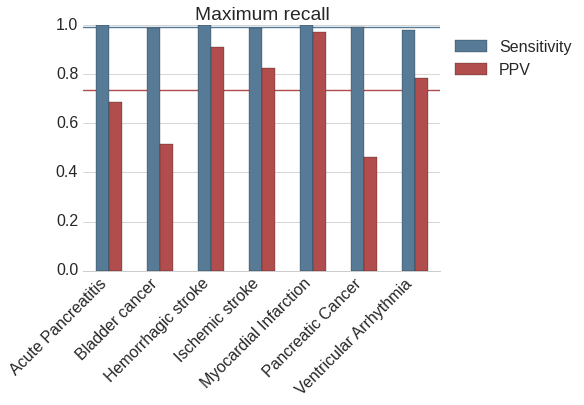

In [82]:
averages_compare = pd.DataFrame([
    ev[ev.variation == 'max-recall'].groupby('event').recall.mean(),
    ev[ev.variation == 'max-recall'].groupby('event').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(measures_palette, xrot=45, ha='right', savefig='max-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Maximum recall", ax=ax)
averages_compare.round(3)

# Compare relations for expansion

                              ICD-9    ICD-10  ICPC-2    READ-2   Average
Expand 3 RN, RB            0.901299  0.912698       1  0.703094  0.879273
Expand 3 PAR, CHD          0.900000  0.993506       1  0.821903  0.928852
Expand 3 RN, CHD, RB, PAR  0.928571  1.000000       1  0.882328  0.952725


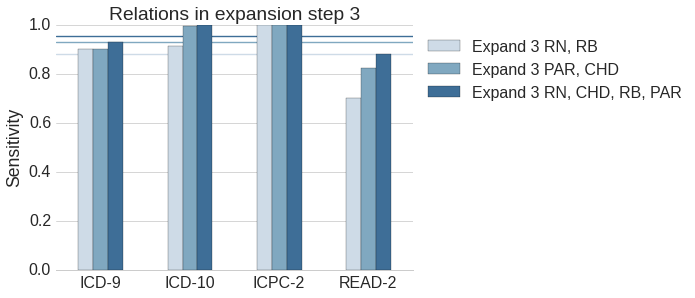

In [83]:
compare_variations = OrderedDict([
    ('3-RN-RB.expand', 'Expand 3 RN, RB'),
    ('3-CHD-PAR.expand', 'Expand 3 PAR, CHD'),
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)

averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), savefig='relations-recall-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:, :-1].T.plot(kind='bar', title="Relations in expansion step 3", ax=ax)
    plt.ylabel(measure_label('recall'))
print(averages_compare)

                              ICD-9    ICD-10    ICPC-2    READ-2   Average
Expand 3 RN, RB            0.485195  0.520532  0.785714  0.745774  0.634304
Expand 3 PAR, CHD          0.446468  0.509343  0.761905  0.728762  0.611620
Expand 3 RN, CHD, RB, PAR  0.462319  0.497555  0.761905  0.742428  0.616052


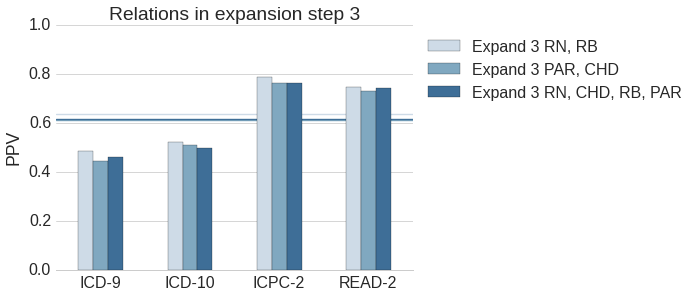

In [84]:
compare_variations = OrderedDict([
    ('3-RN-RB.expand', 'Expand 3 RN, RB'),
    ('3-CHD-PAR.expand', 'Expand 3 PAR, CHD'),
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index=compare_variations)

averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), savefig='relations-recall-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:, :-1].T.plot(kind='bar', title="Relations in expansion step 3", ax=ax)
    plt.ylabel(measure_label('precision'))
print(averages_compare)

                              ICD-9    ICD-10  ICPC-2    READ-2   Average
Expand 4 RN, RB            0.901299  0.912698       1  0.703094  0.879273
Expand 4 PAR, CHD          0.900000  0.993506       1  0.830153  0.930915
Expand 4 RN, CHD, RB, PAR  0.928571  1.000000       1  0.883857  0.953107


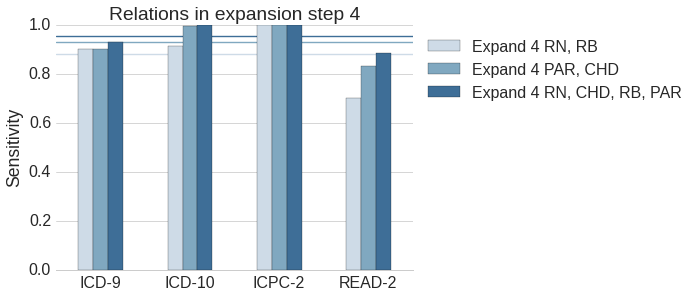

In [85]:
compare_variations = OrderedDict([
    ('4-RN-RB.expand', 'Expand 4 RN, RB'),
    ('4-CHD-PAR.expand', 'Expand 4 PAR, CHD'),
    ('4-RN-CHD-RB-PAR.expand', 'Expand 4 RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)

averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), savefig='relations-recall-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:, :-1].T.plot(kind='bar', title="Relations in expansion step 4", ax=ax)
    plt.ylabel(measure_label('recall'))
print(averages_compare)

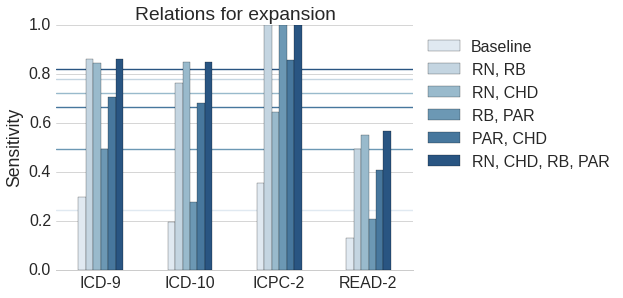

In [86]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)

averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), savefig='relations-recall-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:, :-1].T.plot(kind='bar', title="Relations for expansion", ax=ax)
    plt.ylabel(measure_label('recall'))

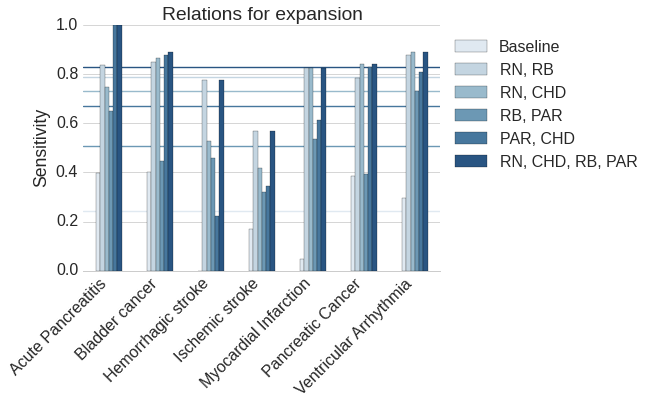

In [87]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='relations-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Relations for expansion", ax=ax)
    plt.ylabel(measure_label('recall'))

# Increasing sensitivity with more expansion steps

,ICD-9,ICD-10,ICPC-2,READ-2,Average
baseline,0.300,0.195,0.357,0.131,0.246
expand$_1$,0.858,0.848,1.000,0.568,0.818
expand$_2$,0.914,1.000,1.000,0.846,0.940
expand$_3$,0.929,1.000,1.000,0.882,0.953
expand$_4$,0.929,1.000,1.000,0.884,0.953


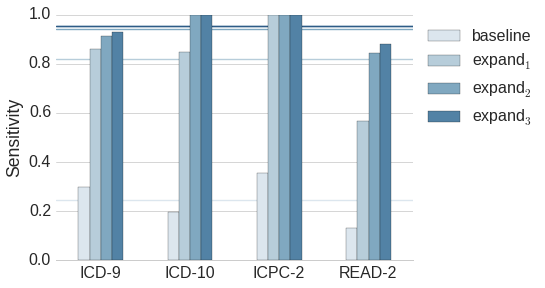

In [88]:
variations_names = OrderedDict([
    ('baseline', 'baseline'),
    ('1-RN-CHD-RB-PAR.expand', 'expand$_1$'),
    ('2-RN-CHD-RB-PAR.expand', 'expand$_2$'),
    ('3-RN-CHD-RB-PAR.expand', 'expand$_3$'),
    ('4-RN-CHD-RB-PAR.expand', 'expand$_4$'),
])
df = pd.DataFrame({
    name: ev[ev.variation == variation].groupby('database').recall.mean()
    for variation, name in variations_names.items()
}).T
df.columns = df.columns.map(database_label)
df = df[coding_systems]
df['Average'] = df.mean(axis=1)

with mystyle(graded_recall_palette(len(variations_names), rev=0), savefig='steps-recall-by-db.pdf'):
    ax = draw_lines(df['Average'])
    df.iloc[:-1,:-1].T.plot(kind='bar', ax=ax)
    plt.ylabel(measure_label('recall'))
    
df.round(3)

## Reasons for low performance in IPCI when including exclusion codes

*Exclusion codes are not in the evaluation any more. See note above.*

The IPCI mapping contains *very* broad codes that are refined with additional terms. For example

- `K24` (Fear of heart attack)
- `K90` (stroke)
- `K93` (Pulmonary embolism)
- `D70` (Dementia) OR "dementia" AND "infarct"
- `U14` (Kidney symptom/complaint ) OR "nier" AND "infarct"

In [89]:
expands_performance = OrderedDict()
for i in [1,2,3,4]:
    v = '{}-RN-CHD-RB-PAR.expand'.format(i)
    df = pd.DataFrame([
        ev[ev.variation == v].groupby('database').recall.mean(),
        ev[ev.variation == v].groupby('database').precision.mean(),
    ])
    df.index = df.index.map(measure_label)
    df.columns = df.columns.map(database_label)
    df = df[coding_systems]
    df['Average'] = df.mean(axis=1)

    #with mystyle(measures_palette, ylim=(0,1), savefig='max-recall-performance-by-db.pdf'):
    #    ax = draw_lines(df['Average'])
    #    df.iloc[:,:-1].T.plot(kind='bar', title='Maximum recall', ax=ax)

    expands_performance['expand_{}'.format(i)] = df

In [90]:
num_concepts = pd.Series(OrderedDict([
    (var_name, ev[(ev.variation == var) & (ev.cuis.notnull())]
                 .groupby('event').first()
                 .cuis.map(json.loads).map(len)
                 .sum())
    for var_name, var in [('baseline0', 'baseline0'), ('baseline', 'baseline')] + \
        [('expand_{}'.format(i), '{}-RN-CHD-RB-PAR.expand'.format(i)) for i in range(1,5)] + \
        [(('max-sensitivity', 'max-recall'))]
])).to_frame('Concepts')
num_concepts

,Concepts
baseline0,77
baseline,46
expand_1,183
expand_2,297
expand_3,335
expand_4,337
max-sensitivity,287


In [91]:
performances = OrderedDict()
performances['baseline_0'] = baseline0_performance
performances['baseline'] = baseline_performance
for v in expands_performance:
    performances[v] = expands_performance[v]
performances['max_sensitivity'] = maxrecall_performance
performances_df = pd.concat(performances).round(3)
performances_df

ICD-9  ICD-10  ICPC-2  READ-2  Average
baseline        Sensitivity  0.300   0.195   0.357   0.131    0.246
                PPV          0.387   0.380   0.500   0.411    0.420
baseline_0      Sensitivity  0.300   0.195   0.357   0.131    0.246
                PPV          0.322   0.380   0.500   0.373    0.394
expand_1        Sensitivity  0.858   0.848   1.000   0.568    0.818
                PPV          0.483   0.558   0.762   0.729    0.633
expand_2        Sensitivity  0.914   1.000   1.000   0.846    0.940
                PPV          0.463   0.509   0.762   0.749    0.621
expand_3        Sensitivity  0.929   1.000   1.000   0.882    0.953
                PPV          0.462   0.498   0.762   0.742    0.616
expand_4        Sensitivity  0.929   1.000   1.000   0.884    0.953
                PPV          0.462   0.497   0.762   0.743    0.616
max_sensitivity Sensitivity  1.000   1.000   1.000   0.966    0.991
                PPV          0.612   0.608   0.857   0.855    0.733

In [92]:
s = (performances_df
     .set_index(performances_df.index.rename(['Variation', 'Measurement']))
     .stack()
     .reset_index()
     .rename(columns={'level_2': 'Terminology', 0: 'Value'})
    )
s.head()

,Variation,Measurement,Terminology,Value
0,baseline,Sensitivity,ICD-9,0.300
1,baseline,Sensitivity,ICD-10,0.195
2,baseline,Sensitivity,ICPC-2,0.357
3,baseline,Sensitivity,READ-2,0.131
4,baseline,Sensitivity,Average,0.246


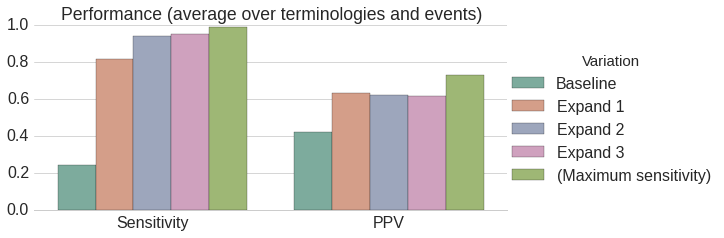

In [93]:
# Remove [s.Terminology == 'Average'] for all terminologies
variation_names = {
    'baseline': 'Baseline',
    'baseline_0': None,
    'expand_1': 'Expand 1',
    'expand_2': 'Expand 2',
    'expand_3': 'Expand 3',
    'expand_4': None,
    'max_sensitivity': '(Maximum sensitivity)'
}
s1 = s.copy()
s1.Variation = s1.Variation.map(variation_names)
s1 = s1[s1.Variation.notnull()]
(sns.factorplot(kind='bar', data=s1[s1.Terminology == 'Average'],
                x='Measurement', y='Value', col='Terminology', hue='Variation',
                saturation=.5, legend=True, legend_out=True, size=4, aspect=2,
                palette=sns.color_palette("Set2", 7),
                hue_order=['Baseline', 'Expand 1', 'Expand 2', 'Expand 3', '(Maximum sensitivity)'])
  .set_titles("Performance (average over terminologies and events)")
  .set_xlabels('')
  .set_ylabels('')
  .set(ylim=(0, 1))
  .despine(left=True))

,ICD-9,ICD-10,ICPC-2,READ-2,Average
Baseline,0.387,0.380,0.500,0.411,0.420
Expansion 1 step,0.483,0.558,0.762,0.729,0.633
Expansion 2 steps,0.463,0.509,0.762,0.749,0.621
Expansion 3 steps,0.462,0.498,0.762,0.742,0.616
Expansion 4 steps,0.462,0.497,0.762,0.743,0.616


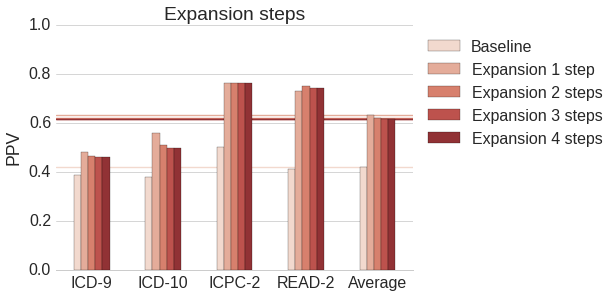

In [94]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', 'Expansion 1 step'),
    ('2-RN-CHD-RB-PAR.expand', 'Expansion 2 steps'),
    ('3-RN-CHD-RB-PAR.expand', 'Expansion 3 steps'),
    ('4-RN-CHD-RB-PAR.expand', 'Expansion 4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_precision_palette(len(compare_variations), rev=0), savefig='steps-precision-by-db.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('precision'))
averages_compare.round(3)

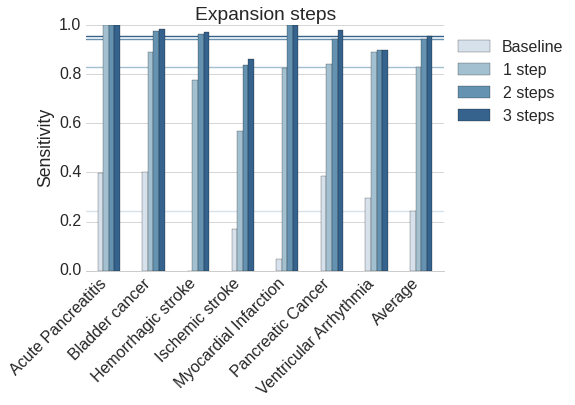

In [95]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
#    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_recall_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='steps-recall-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('recall'))

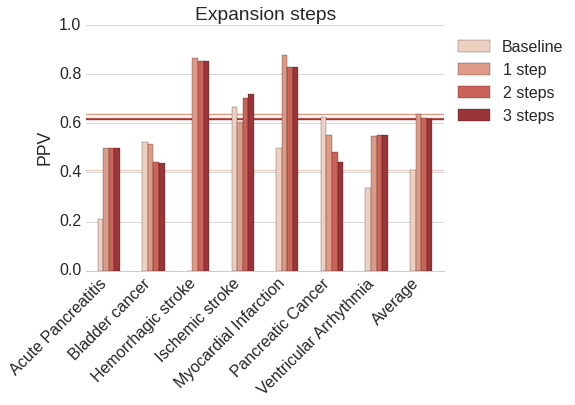

In [96]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
#    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()
averages_compare['Average'] = averages_compare.mean(axis=1)

with mystyle(graded_precision_palette(len(compare_variations), rev=0), xrot=45, ha='right', savefig='steps-precision-by-event.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.T.plot(kind='bar', title="Expansion steps", ax=ax)
    plt.ylabel(measure_label('precision'))

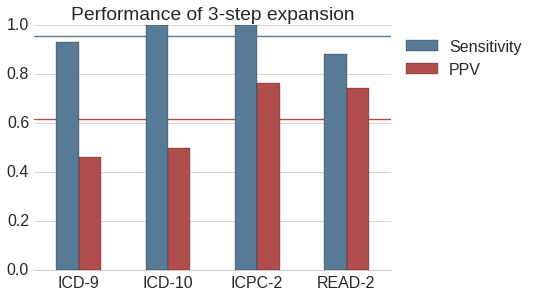

In [97]:
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare = averages_compare[coding_systems]
averages_compare['Average'] = averages_compare.mean(axis=1)

name = 'expansion3-performance-by-db'
with mystyle(measures_palette, savefig=name+'.pdf'):
    ax = draw_lines(averages_compare['Average'])
    averages_compare.iloc[:,:-1].T.plot(kind='bar', title="Performance of 3-step expansion", ax=ax)
averages_compare.to_csv(name+'.csv')

# FN error-analysis

In [98]:
variation = '3-RN-CHD-RB-PAR.expand'

with open("../{}.{}.error-analyses.yaml".format(PROJECT, variation)) as f:
    error_analyses = yaml.load(f)
    
def get_category(fn_or_fp, database, event, code):
    if database in error_analyses[fn_or_fp] and event in error_analyses[fn_or_fp][database]:
        return error_analyses[fn_or_fp][database][event]['code-categories'].get(code) or '?'
    else:
        return '??'

evs = ev[(ev.variation == variation) & ev.fn.notnull()][['event', 'database', 'fn', 'fp']]

fn = evs.apply(lambda row: pd.Series(row.fn), axis=1).stack().reset_index(level=1, drop=True)
fn.name = 'code'
# fns : | event | database | code |
fns = evs.drop(['fn', 'fp'], axis=1).join(fn, how='inner').drop_duplicates()
fns['category'] = fns.apply(lambda r: get_category('fn', r.database, r.event, r.code), axis=1)

fp = evs.apply(lambda row: pd.Series(row.fp), axis=1).stack().reset_index(level=1, drop=True)
fp.name = 'code'
# fps : | event | database | code |
fps = evs.drop(['fn', 'fp'], axis=1).join(fp, how='inner').drop_duplicates()
fps['category'] = fps.apply(lambda r: get_category('fp', r.database, r.event, r.code), axis=1)

fns.groupby(['category', 'database']).code.aggregate(lambda s: set(s)).map(', '.join).to_frame()

code
category          database                                                                                                  
database-specific CPRD      3283., 7L1H., 7L1Hy, 8531., 7L1Hz, 70041, B83z., 8532., 70043, 853Z., 853.., 7L1H4, 70082, 70042
                  Medicare                                                            433.01, 433.31, 433.21, 433.81, 433.11
next-expansion    CPRD                                                                     BB5Bz, BB5Cz, B8086, BB5C., BB5B.
not-in-dnf        CPRD                                                       7L1H7, BBd9., G64z4, 1O0.., BBaz., 7L1H6, BBa..

In [99]:
fps.groupby(['category', 'database']).code.aggregate(lambda s: set(s)).map(', '.join).to_frame()

code
category database                                                                                                     
in-dnf   CPRD      B80zz, Jyu9., G66.., G572z, B835., G63z., G6z.., J670y, BB14., G572., B7D30, ByuFE, BB2K., Bz......
         GePaRD    D41.4, D48.9, C80.1, C80.0, D44, I21.19, D09.9, K92, G46.6, C26.0, D07.4, I21.29, K85, I49.01, D...
         IPCI                                                                                                 A79, U75
         Medicare  189.9, 194, 239, 410.70, 237, 236, 239.8, 156.2, 194.8, 234.8, 234, 189, 236.9, 410.90, 238, 195...
other-fp CPRD      R0003, 32K3., 1969., G57.., J67z., R090z, J67.., G57z., B7D3., BB5.., G8y0., 32J.., G5753, BB2A....
         GePaRD    C15.-C26, C64.-C68.9, K86.9, C64.-C68, D30.3, C00.-D48.9, K86.1, I60.-I69.9, D13.6, K90.-K93.9, ...
         IPCI                                                                                                      K80
         Medicare  239.-239.99, 179.-189.99, 427, 223.3, 570.-579.99, 459.0, 190.-199.99, 140.-239.99, 577, 789.00,...

In [100]:
code_counts = pd.Series({
    database: len(set(mappings.all_codes(database)))
    for database in databases.databases()
})
code_counts.ix['All'] = code_counts.sum()
code_counts.index.name = 'database'

def category_label(category):
    return {
        # FN
        'not-in-dnf': 'Not in UMLS',
        'database-specific': 'DB specific',
        'next-expansion': 'expansion_{4}',
        'isolated': 'Isolated',
        # FP
        'in-dnf': 'Cosynonym',
        'other-fp': 'Indexing FP',
    }.get(category, category)

def counts(code_categories, FN_or_FP):
    "code_categories : | code | category |"
    # (database, category) | int
    s1 = code_categories.groupby('database').category.value_counts()
    # category | int
    s2 = code_categories.category.value_counts()
    s2.index = pd.MultiIndex.from_product([['Overall'], s2.index])
    res = pd.concat([s1, s2]).to_frame('count')
    res['%'] = (res['count'] / s2.sum()).map('{:.1%}'.format)
    #res['% (mapping)'] = (res['count'] / code_counts).map('{:.1%}'.format)

    res = res.rename(columns={'count': '{} category'.format(FN_or_FP)}).reset_index()
    res['category'] = res['category'].map(category_label)
    res['database'] = res['database'].map(lambda db: db if db == 'Overall' else database_label(db))
    return res

counts(fps, 'FP')

,database,category,FP category,%
0,READ-2,Cosynonym,43,18.4%
1,READ-2,Indexing FP,17,7.3%
2,ICD-10,Cosynonym,66,28.2%
3,ICD-10,Indexing FP,30,12.8%
4,ICPC-2,Cosynonym,3,1.3%
5,ICPC-2,Indexing FP,1,0.4%
6,ICD-9,Cosynonym,52,22.2%
7,ICD-9,Indexing FP,22,9.4%
8,Overall,Cosynonym,164,70.1%
9,Overall,Indexing FP,70,29.9%


In [101]:
counts(fns, 'FN')

,database,category,FN category,%
0,READ-2,DB specific,14,40.0%
1,READ-2,Not in UMLS,11,31.4%
2,READ-2,expansion_{4},5,14.3%
3,ICD-9,DB specific,5,14.3%
4,Overall,DB specific,19,54.3%
5,Overall,Not in UMLS,11,31.4%
6,Overall,expansion_{4},5,14.3%


```
measures = OrderedDict([
    ('recall', measure_label('recall')),
    ('recall_in_umls', '{} to reference in UMLS'.format(measure_label('recall'))),
    ('recall_without_exclusions', '{} over inclusion codes'.format(measure_label('recall'))),
    ('recall_without_exclusions_in_umls', '{} over inclusion codes in UMLS'.format(measure_label('recall'))),
    ('', ''),
    ('precision', measure_label('precision')),
    ('precision_over_dnf', '{} over maximum recall'.format(measure_label('precision'))),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('database')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.database.unique()), index=ev.database.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(database_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")
```

```
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand'].groupby('event')[measure].mean()\
        if measure else\
        pd.Series([0] * len(ev.event.unique()), index=ev.event.unique())
    for measure in measures
], index=measures.values())
averages_compare.columns = averages_compare.columns.map(event_label)

p = sns.color_palette(graded_recall_palette(5)[:-1] + [(1,1,1)] + graded_precision_palette(3)[:-1])
with mystyle(p, savefig='expansion3-error-analysis-by-db.pdf', xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Error analysis of 3-step expansion")
```

```
residuals = ev[ev.variation == '3-RN-CHD-RB-PAR.expand']


residuals.fn_inclusions_in_umls = residuals.fn_inclusions_in_umls\
    .fillna('NaN').map(json.loads)
def get_missed(row):
    if math.isnan(row.recall_without_exclusions_in_umls):
        return ''
    else:
        reference = set(json.loads(row.reference_inclusions_in_umls))
        return "{}/{}".format(len(row.fn_inclusions_in_umls), len(reference))
                                     
residuals['missed'] = residuals.apply(get_missed, axis=1)

residuals.fn_inclusions_in_umls = residuals.fn_inclusions_in_umls\
    .map(lambda s: ', '.join(s) if type(s) == list else 'N/A')
residuals.database = residuals.database.map(database_label)
residuals.event = residuals.event.map(event_label)
residuals.recall_without_exclusions_in_umls = residuals.recall_without_exclusions_in_umls\
    .map('{:.2f}'.format)
residuals = residuals.sort_index(by=['database', 'event']).reset_index(drop=True)
    
residuals = residuals[['database', 'event', 'recall_without_exclusions_in_umls', 'missed', 'fn_inclusions_in_umls']]
residuals.columns = ["Database", "Event", "Recall", "Missed", "Residual FNs"]

#residuals = residuals.set_index(['Database', 'Event'])["Residual FNs"].unstack()
residuals
```

# Removing unused codes

```python
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-baseline-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_label)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-baseline-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations)), savefig='filtered-expansion3-precision-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered expansion")
    plt.ylabel(measure_label('precision'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-recall-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('recall'))
```
```python
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    ev[ev.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right', savefig='filtered-expansion3-precision-by-event.pdf'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('precision'))
```
```python
measures = ['recall', 'precision']
averages_compare = pd.DataFrame([
    ev[ev.variation == '3-RN-CHD-RB-PAR.expand.filter-gen'].groupby('database')[measure].mean()
    for measure in measures
], index=map(measure_label, measures))
averages_compare.columns = averages_compare.columns.map(database_label)
#averages_compare.index = compare_variations.values()

with mystyle(measures_palette, savefig='filtered-expansion3-performance-by-db.pdf'):
    averages_compare.T.plot(kind='bar', title="Performance of filtered 3-step expansion")
```

The drop in PPV for Myocardial infarction is caused by the mapping to codes `410.*` (Acute myocardial infarction) in Medicare which is *not* used in the ARS database.

# Codes in reference mappings, not in databases
Codes that might be removed from the TP when filtering.

```python
stats = DataFrame()
stats['In ref'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['Not in DB'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['Not in DB'] / stats['In ref']).map("{:.2%}".format)
stats['Codes'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.aggregate(lambda vs: ', '.join(set(vs)))
stats
```